In [1]:
import requests
from bs4 import BeautifulSoup
import time
from tqdm.notebook import tqdm
from urllib.parse import quote

import pandas as pd
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.common.alert import Alert

from datetime import datetime, timedelta

import numpy as np
import statistics
from matplotlib import font_manager, rc 
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns

#마이너스 표시
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Malgun Gothic')

In [2]:
movie_df = pd.read_excel('./data/완_기간별_일별_170101_to_230509_ver2.xlsx')
movie_df.head()

,순위,영화명,개봉일,대표국적,국적,제작사,배급사,등급,장르,감독,...,매출액,누적매출액,관객수,누적관객수,스크린수,상영횟수,기준연도,기준월,개봉연도,개봉월
0,1,너의 이름은.,2017-01-04,일본,일본,NaN,플러스엠 엔터테인먼트,12세이상관람가,"애니메이션,드라마,멜로/로맨스",신카이 마코토,...,2809088900,9745292442,333008,1182465,947,4101,2017,1,2017,1
1,3,모아나,2017-01-12,미국,미국,NaN,월트디즈니컴퍼니코리아 유한책임회사,전체관람가,애니메이션,"론 클레멘츠,존 머스커",...,7738000,9712000,910,1192,6,6,2017,1,2017,1
2,4,패신저스,2017-01-04,미국,미국,NaN,유니버설픽쳐스인터내셔널 코리아(유),12세이상관람가,"어드벤처,SF",모튼 틸덤,...,1107502600,4176443418,129810,504393,608,2272,2017,1,2017,1
3,9,눈의 여왕 3: 눈과 불의 마법대결,2017-01-04,러시아,러시아,NaN,(주)이수C&E,전체관람가,"애니메이션,어드벤처,가족,판타지",알렉세이 트시칠린,...,535436000,1828596400,67605,242171,524,1163,2017,1,2017,1
4,10,사랑하기 때문에,2017-01-04,한국,한국,(주)에이디사공육,(주)넥스트엔터테인먼트월드(NEW),12세이상관람가,"코미디,멜로/로맨스",주지홍,...,450612400,1968850940,53856,246167,542,1533,2017,1,2017,1


# 상관관계

In [5]:
movie_df_corr = movie_df[['매출액', '누적매출액', '관객수', '누적관객수', '스크린수', '상영횟수']]
corr_df = movie_df_corr.corr()
corr_df

,매출액,누적매출액,관객수,누적관객수,스크린수,상영횟수
매출액,1.000000,0.190272,0.993342,0.189412,0.698389,0.792487
누적매출액,0.190272,1.000000,0.188367,0.992949,0.252035,0.229867
관객수,0.993342,0.188367,1.000000,0.190428,0.695585,0.792454
누적관객수,0.189412,0.992949,0.190428,1.000000,0.246365,0.227040
스크린수,0.698389,0.252035,0.695585,0.246365,1.000000,0.954058
상영횟수,0.792487,0.229867,0.792454,0.227040,0.954058,1.000000


<Axes: >

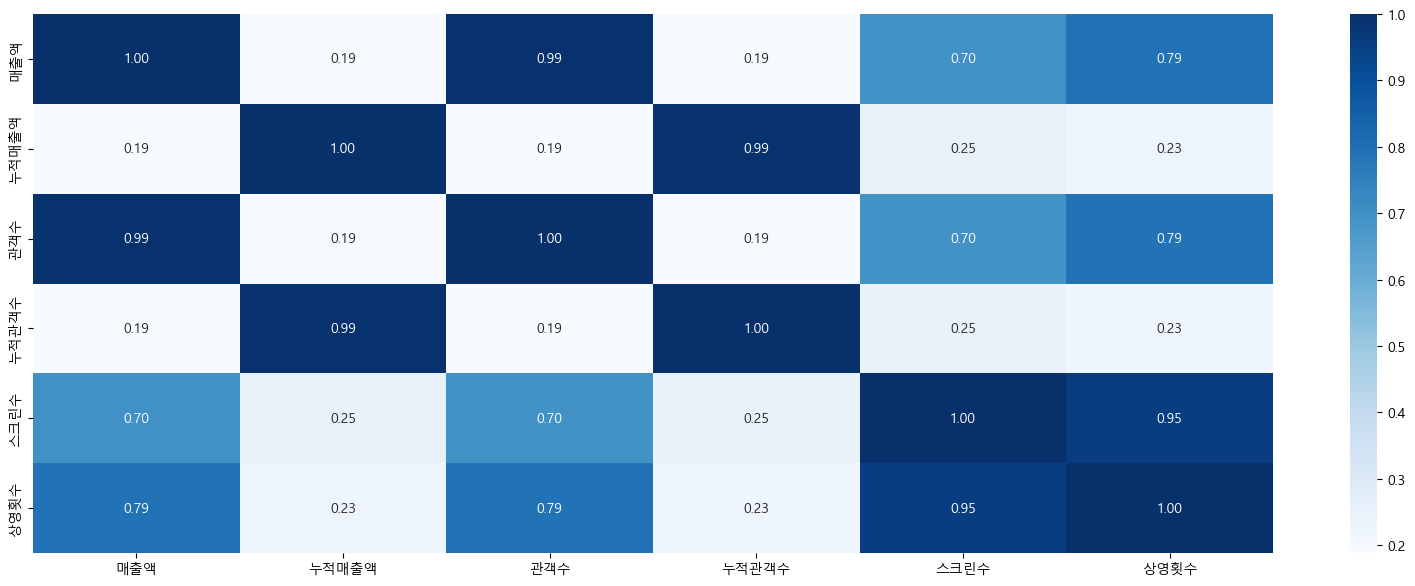

In [6]:
plt.figure(figsize=(20,7))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="Blues")

# 매출 변화

In [9]:
movie_info = movie_df[['영화명','개봉일','대표국적','등급','기준일','매출액','누적매출액','관객수','누적관객수','스크린수','상영횟수','기준연도','기준월','개봉연도','개봉월']]
movie_info.head(3)

,영화명,개봉일,대표국적,등급,기준일,매출액,누적매출액,관객수,누적관객수,스크린수,상영횟수,기준연도,기준월,개봉연도,개봉월
0,너의 이름은.,2017-01-04,일본,12세이상관람가,2017-01-08,2809088900,9745292442,333008,1182465,947,4101,2017,1,2017,1
1,모아나,2017-01-12,미국,전체관람가,2017-01-08,7738000,9712000,910,1192,6,6,2017,1,2017,1
2,패신저스,2017-01-04,미국,12세이상관람가,2017-01-08,1107502600,4176443418,129810,504393,608,2272,2017,1,2017,1


In [21]:
movie_year_info = movie_info.groupby(['기준연도']).agg({'매출액':'sum', '관객수':'sum', '스크린수':'sum', '상영횟수':'sum'})[1:-1]
movie_year_info

,매출액,관객수,스크린수,상영횟수
기준연도,,,,
2018,1803723964724,214885747,2048592,6486492
2019,1905789216740,225349152,2202753,6819164
2020,499808908001,57991480,1699998,4230505
2021,575737892070,59492547,1915754,4550575
2022,1156311591025,112287221,2085868,5653085


<Axes: >

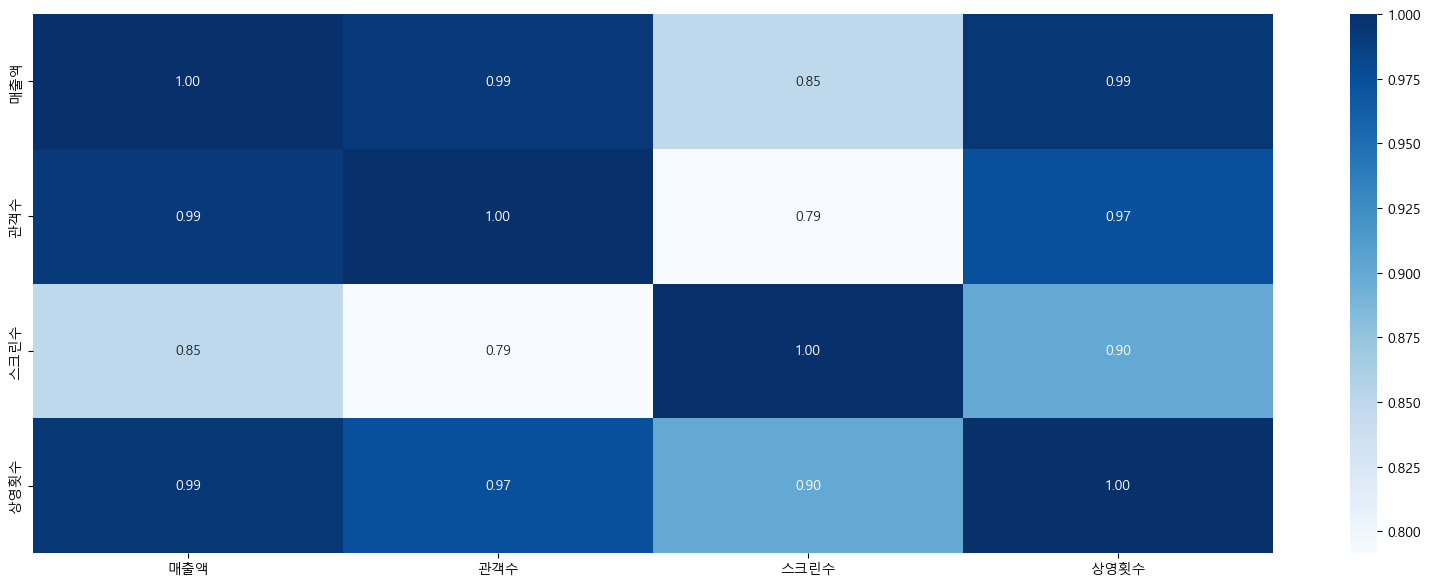

In [56]:
plt.figure(figsize=(20,7))
sns.heatmap(movie_year_info.corr(), annot=True, fmt=".2f", cmap="Blues")

In [27]:
movie_year_info['매출액']

기준연도
2018    1803723964724
2019    1905789216740
2020     499808908001
2021     575737892070
2022    1156311591025
Name: 매출액, dtype: int64

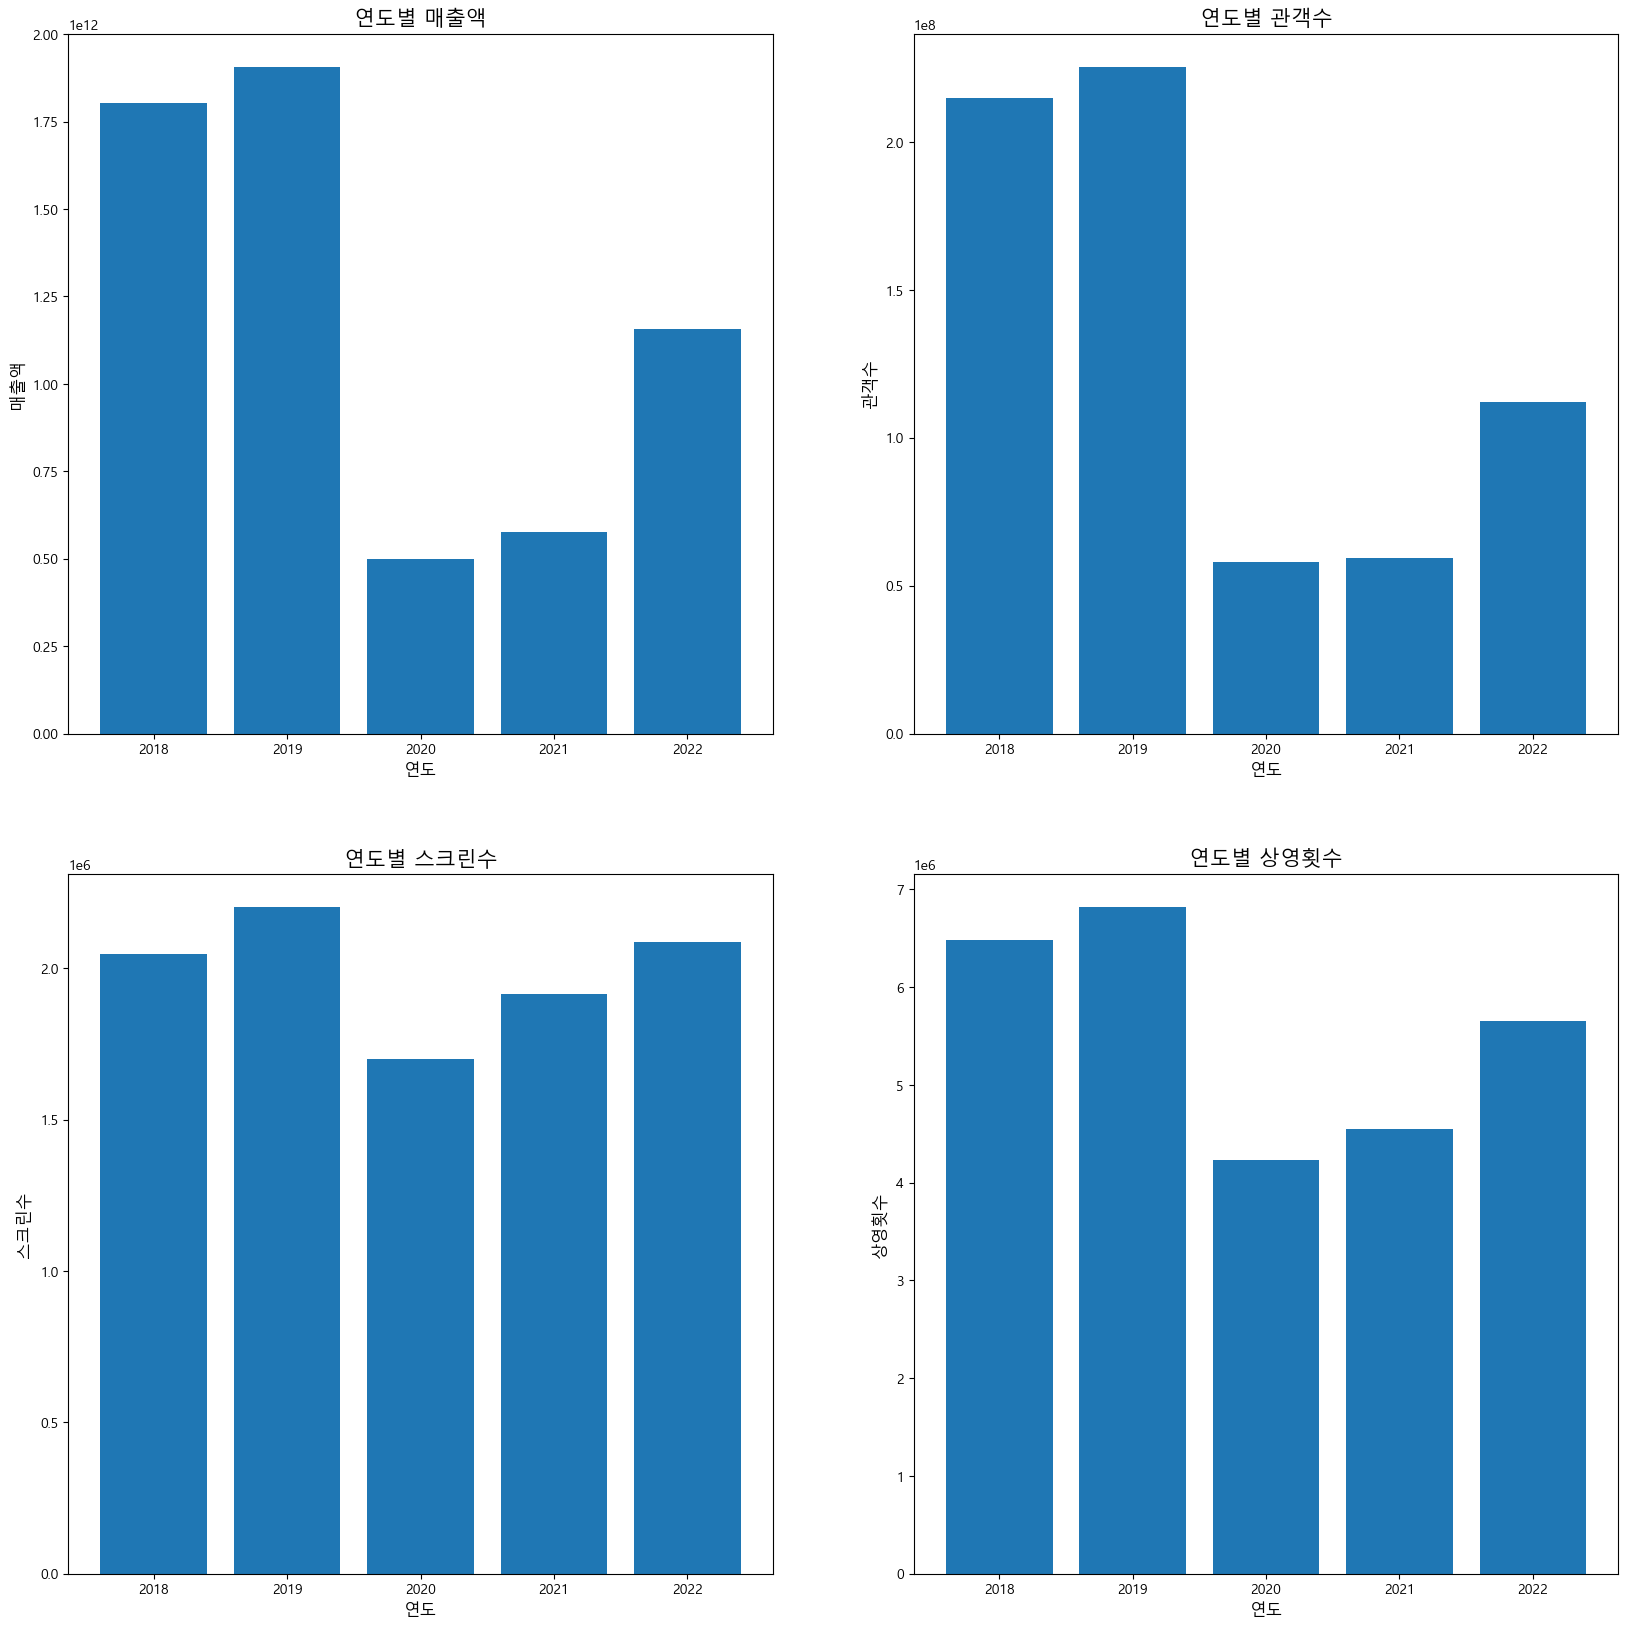

In [54]:
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(2,2,1)
ax1.bar(movie_year_info['매출액'].index, movie_year_info['매출액'].values)

ax1.set_title('연도별 매출액', size=15)
ax1.set_xlabel('연도',size=12)
ax1.set_ylabel('매출액',size=12)

ax2 = fig.add_subplot(2,2,2)
ax2.bar(movie_year_info['관객수'].index, movie_year_info['관객수'].values)

ax2.set_title('연도별 관객수', size=15)
ax2.set_xlabel('연도',size=12)
ax2.set_ylabel('관객수',size=12)

ax3 = fig.add_subplot(2,2,3)
ax3.bar(movie_year_info['스크린수'].index, movie_year_info['스크린수'].values)

ax3.set_title('연도별 스크린수', size=15)
ax3.set_xlabel('연도',size=12)
ax3.set_ylabel('스크린수',size=12)

ax4 = fig.add_subplot(2,2,4)
ax4.bar(movie_year_info['상영횟수'].index, movie_year_info['상영횟수'].values)

ax4.set_title('연도별 상영횟수', size=15)
ax4.set_xlabel('연도',size=12)
ax4.set_ylabel('상영횟수',size=12)

plt.show()

In [57]:
movie_year_info

,매출액,관객수,스크린수,상영횟수
기준연도,,,,
2018,1803723964724,214885747,2048592,6486492
2019,1905789216740,225349152,2202753,6819164
2020,499808908001,57991480,1699998,4230505
2021,575737892070,59492547,1915754,4550575
2022,1156311591025,112287221,2085868,5653085


In [ ]:
# 총매출이 줄었다는것 = 관객수가 줄었다

In [ ]:
# 4월에 매출이 작고 8월에 가장큼 - 장르 비교?
# 그 분기에 가장 많이 성공한 영화?
# 개봉한 영화?

In [60]:
movie_year_month_info = movie_info.groupby(['기준연도','기준월']).agg({'매출액':'sum', '관객수':'sum', '스크린수':'sum', '상영횟수':'sum'})
movie_year_month_info

매출액       관객수    스크린수    상영횟수
기준연도 기준월                                        
2017 1    149844517327  18466312  126799  398024
     2    119222010654  14910621  162208  473119
     3    110757411220  13597595  161635  483415
     4     89172406575  11038818  155369  471503
     5    148934911530  18574231  170396  529942
...                ...       ...     ...     ...
2023 1    123808074711  11220380  207405  525120
     2     62335465454   5942445  186764  427956
     3     79804374946   7445640  190480  465873
     4     69957651381   6902721  174795  437812
     5     34446431119   3403482   37771  102341

[77 rows x 4 columns]

In [63]:
movie_month_info = movie_info.groupby(['기준월']).agg({'매출액':'sum', '관객수':'sum', '스크린수':'sum', '상영횟수':'sum'})
movie_month_info

,매출액,관객수,스크린수,상영횟수
기준월,,,,
1,820381853029,94710359,1202625,3282678
2,615226631172,71821257,1131489,3082184
3,488665686905,55789692,1130450,2956570
4,450454478625,51523300,1063178,2764665
5,678403960566,75999175,1001151,2800387
6,680485991288,76633954,922748,2818332
7,799942990332,91137264,1010203,3112748
8,998174706293,116139067,1085261,3308440
9,546266390898,61991811,1015737,2895674
